In [5]:
import pandas as pd
from scipy.special import softmax
from tqdm import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertForSequenceClassification,
    BertTokenizer,
    pipeline,
)

tqdm.pandas()

In [6]:
file_path = '../Crawl_Data/Data/yahoo_news_20241221_044513.csv'
df = pd.read_csv(file_path, )
df.head()

,Unnamed: 0,TITLE,LINK,CONTENT,RELEASE_TIME,Human Label
0,0,"Tesla recall, Netflix-FIFA deal, Apple: Market...",https://finance.yahoo.com/video/tesla-recall-n...,Yahoo Finance host Rachelle Akuffo tackles thr...,3 hours ago,neutral
1,1,Elon Musk Told The U.N. If They Could Show A P...,https://finance.yahoo.com/news/elon-musk-told-...,In a world where hunger kills more people each...,9 minutes ago,neutral
2,2,"Magnificent Seven Stocks: Nvidia, Tesla Revers...",https://finance.yahoo.com/m/4205eaa9-f620-3a0b...,"Dubbed the Magnificent Seven stocks, Apple, Mi...",14 minutes ago,positive
3,3,"These Stocks Are Moving the Most Today: FedEx,...",https://finance.yahoo.com/m/57c66b45-0b6c-3ce7...,"FedEx, the shipping and logistics giant, plans...",1 hour ago,positive
4,4,Hyundai and Samsung in talks for automotive ch...,https://finance.yahoo.com/news/hyundai-samsung...,Hyundai aims to establish a domestic supply ch...,1 hour ago,neutral


In [7]:
print(df.shape)
df.columns.tolist()

(400, 6)


['Unnamed: 0', 'TITLE', 'LINK', 'CONTENT', 'RELEASE_TIME', 'Human Label']

In [8]:
df.isnull().sum().sum()

0

In [9]:
df = df[['TITLE','CONTENT','RELEASE_TIME','Human Label']]
df = df.reset_index().rename(columns={'index':'Id'})
df.head()

,Id,TITLE,CONTENT,RELEASE_TIME,Human Label
0,0,"Tesla recall, Netflix-FIFA deal, Apple: Market...",Yahoo Finance host Rachelle Akuffo tackles thr...,3 hours ago,neutral
1,1,Elon Musk Told The U.N. If They Could Show A P...,In a world where hunger kills more people each...,9 minutes ago,neutral
2,2,"Magnificent Seven Stocks: Nvidia, Tesla Revers...","Dubbed the Magnificent Seven stocks, Apple, Mi...",14 minutes ago,positive
3,3,"These Stocks Are Moving the Most Today: FedEx,...","FedEx, the shipping and logistics giant, plans...",1 hour ago,positive
4,4,Hyundai and Samsung in talks for automotive ch...,Hyundai aims to establish a domestic supply ch...,1 hour ago,neutral


In [10]:
text_example = df['CONTENT'][2]
text_example

'Dubbed the Magnificent Seven stocks, Apple, Microsoft, Google parent Alphabet, Amazon.com, Nvidia, Meta Platforms and Tesla lived up to their name in 2023 with big gains. And all of them boasted solid year-to-date gains in the final month of 2024.'

## FinancialBERT

In [11]:
Fin_model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
Fin_tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

In [12]:
def polarity_scores_financialBERT(text):
    encoded_text = Fin_tokenizer(text, return_tensors='pt')
    output = Fin_model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'financialBERT_neg': scores[0],
        'financialBERT_neu': scores[1],
        'financialBERT_pos': scores[2]
    }

    return scores_dict

In [13]:
res = polarity_scores_financialBERT(text_example)
res

{'financialBERT_neg': 8.471948e-05,
 'financialBERT_neu': 8.4637024e-05,
 'financialBERT_pos': 0.9998306}

## DistilRoberta

In [14]:
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
distilroberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
distilroberta_model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [15]:
def polarity_scores_distilRoberta(text):
    encoded_text = distilroberta_tokenizer(text, return_tensors='pt')
    output = distilroberta_model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'distilRoberta_neg': scores[0],
        'distilRoberta_neu': scores[1],
        'distilRoberta_pos': scores[2]
    }

    return scores_dict

In [16]:
res = polarity_scores_distilRoberta(text_example)
res

{'distilRoberta_neg': 0.00024128768,
 'distilRoberta_neu': 8.422791e-05,
 'distilRoberta_pos': 0.99967444}

In [17]:
sentiment_results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        title = row['TITLE']
        content = row['CONTENT']
        cid = row['Id']
        vader_results = polarity_scores_financialBERT(content)
        roberta_results = polarity_scores_distilRoberta(content)
        both = {**vader_results, **roberta_results}
        sentiment_results[cid] = both
    except RuntimeError:
        print(f'Broke for cid {cid}')

100%|██████████| 400/400 [02:52<00:00,  2.32it/s]


In [18]:
results_df = pd.DataFrame(sentiment_results).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df.head()

,Id,financialBERT_neg,financialBERT_neu,financialBERT_pos,distilRoberta_neg,distilRoberta_neu,distilRoberta_pos
0,0,0.000280,0.996714,0.003006,0.000332,0.001653,0.998015
1,1,0.002570,0.980410,0.017021,0.000523,0.981101,0.018375
2,2,0.000085,0.000085,0.999831,0.000241,0.000084,0.999674
3,3,0.008248,0.074243,0.917510,0.004953,0.000112,0.994934
4,4,0.000095,0.999830,0.000075,0.000057,0.999788,0.000155


## The Transformers Pipeline

In [19]:
Financial_pipe = pipeline("sentiment-analysis", model=Fin_model, tokenizer=Fin_tokenizer)
Distilroberta_pipe = pipeline("text-classification", model=distilroberta_model, tokenizer=distilroberta_tokenizer)

Device set to use cpu
Device set to use cpu


In [20]:
print(Financial_pipe(text_example))
Distilroberta_pipe(text_example)

[{'label': 'positive', 'score': 0.9998306035995483}]


[{'label': 'positive', 'score': 0.9996744394302368}]

In [21]:
def get_sentiment_through_pipeline(text, pipeline):
    try:
        # Get the sentiment result for the text
        result = pipeline(text)[0] 
        return result['label'], result['score']
    except Exception as e:
        print(f"Error processing text: {text} - {e}")
        return None, None
    
df[['FinancialBERT_label', 'FinancialBERT_score']] = df['CONTENT'].progress_apply(lambda x: pd.Series(get_sentiment_through_pipeline(x, Financial_pipe)))
df[['Distilroberta_label', 'Distilroberta_score']] = df['CONTENT'].progress_apply(lambda x: pd.Series(get_sentiment_through_pipeline(x, Distilroberta_pipe)))

100%|██████████| 400/400 [00:43<00:00,  9.12it/s]


In [22]:
results_df = results_df.merge(df, how='left')
results_df.head()

,Id,financialBERT_neg,financialBERT_neu,financialBERT_pos,distilRoberta_neg,distilRoberta_neu,distilRoberta_pos,TITLE,CONTENT,RELEASE_TIME,Human Label,FinancialBERT_label,FinancialBERT_score,Distilroberta_label,Distilroberta_score
0,0,0.000280,0.996714,0.003006,0.000332,0.001653,0.998015,"Tesla recall, Netflix-FIFA deal, Apple: Market...",Yahoo Finance host Rachelle Akuffo tackles thr...,3 hours ago,neutral,neutral,0.996714,positive,0.998015
1,1,0.002570,0.980410,0.017021,0.000523,0.981101,0.018375,Elon Musk Told The U.N. If They Could Show A P...,In a world where hunger kills more people each...,9 minutes ago,neutral,neutral,0.980410,neutral,0.981101
2,2,0.000085,0.000085,0.999831,0.000241,0.000084,0.999674,"Magnificent Seven Stocks: Nvidia, Tesla Revers...","Dubbed the Magnificent Seven stocks, Apple, Mi...",14 minutes ago,positive,positive,0.999831,positive,0.999674
3,3,0.008248,0.074243,0.917510,0.004953,0.000112,0.994934,"These Stocks Are Moving the Most Today: FedEx,...","FedEx, the shipping and logistics giant, plans...",1 hour ago,positive,positive,0.917510,positive,0.994934
4,4,0.000095,0.999830,0.000075,0.000057,0.999788,0.000155,Hyundai and Samsung in talks for automotive ch...,Hyundai aims to establish a domestic supply ch...,1 hour ago,neutral,neutral,0.999830,neutral,0.999788


In [23]:
results_df.to_excel('financial_news_results.xlsx', index=False)

### Evaluation

In [25]:
from sklearn.metrics import accuracy_score, classification_report

# Compute accuracy for FinancialBERT
finbert_accuracy = accuracy_score(results_df['Human Label'], results_df['FinancialBERT_label'])
finbert_report = classification_report(results_df['Human Label'], results_df['FinancialBERT_label'])

# Compute accuracy for DistilRoBERTa
distilroberta_accuracy = accuracy_score(results_df['Human Label'], results_df['Distilroberta_label'])
distilroberta_report = classification_report(results_df['Human Label'], results_df['Distilroberta_label'])


In [26]:
print("FinancialBERT Accuracy:", finbert_accuracy)
print("FinancialBERT Classification Report:\n", finbert_report)

print("\nDistilRoBERTa Accuracy:", distilroberta_accuracy)
print("DistilRoBERTa Classification Report:\n", distilroberta_report)

FinancialBERT Accuracy: 0.9025
FinancialBERT Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.89      0.90        63
     neutral       0.95      0.85      0.89       196
    positive       0.85      0.99      0.91       141

    accuracy                           0.90       400
   macro avg       0.90      0.91      0.90       400
weighted avg       0.91      0.90      0.90       400


DistilRoBERTa Accuracy: 0.8325
DistilRoBERTa Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.95      0.81        63
     neutral       0.95      0.70      0.81       196
    positive       0.79      0.96      0.87       141

    accuracy                           0.83       400
   macro avg       0.82      0.87      0.83       400
weighted avg       0.86      0.83      0.83       400



In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix


finbert_precision = precision_score(results_df['Human Label'], results_df['FinancialBERT_label'], average='macro')
finbert_recall = recall_score(results_df['Human Label'], results_df['FinancialBERT_label'], average='macro')

distilroberta_precision = precision_score(results_df['Human Label'], results_df['Distilroberta_label'], average='macro')
distilroberta_recall = recall_score(results_df['Human Label'], results_df['Distilroberta_label'], average='macro')


print("FinancialBERT Precision:", round(finbert_precision, 4))
print("FinancialBERT Recall:", round(finbert_recall, 4))
print("\nDistilRoBERTa Precision:", round(distilroberta_precision, 4))
print("DistilRoBERTa Recall:", round(distilroberta_recall, 4))



FinancialBERT Precision: 0.9015
FinancialBERT Recall: 0.9072

DistilRoBERTa Precision: 0.8172
DistilRoBERTa Recall: 0.8713


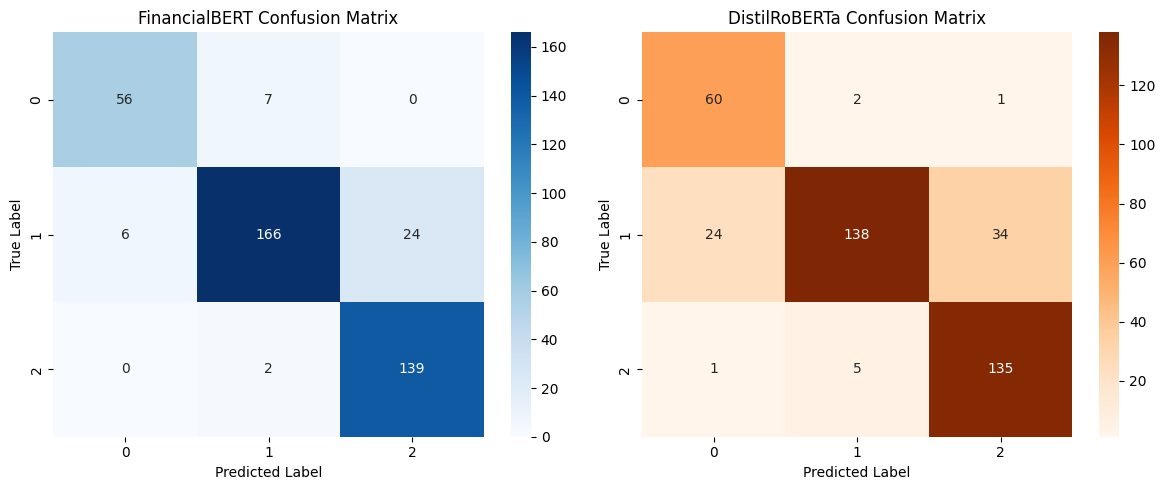

In [28]:
# Compute confusion matrices
finbert_cm = confusion_matrix(results_df['Human Label'], results_df['FinancialBERT_label'])
distilroberta_cm = confusion_matrix(results_df['Human Label'], results_df['Distilroberta_label'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(finbert_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("FinancialBERT Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(distilroberta_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title("DistilRoBERTa Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [24]:
# mismatched_count = (results_df['FinancialBERT_label'] != results_df['Distilroberta_label']).sum()
# mismatched_count